## 1. Create DataLoader, Model with LoRA and Influence Function

In [ ]:
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

#### DataLoader
task_to_keys = {
    "cola": ("sentence", None),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "wnli": ("sentence1", "sentence2"),
}

def flip_label(example, ind, noise_index):
    '''
    Flip the label to make the noisy datapoints
    '''
    if ind in noise_index:
        example["label"] = 1 - example["label"]
    return example

def load_noisy_dataset_by_task(task="mrpc", noise_ratio=0.1):
    glue_datasets = load_dataset("glue", task)
    n_train = len(glue_datasets['train'])
    n_val = len(glue_datasets['validation'])
    if n_train > 4500 and n_val > 500:
        new_n_train_list = np.random.choice(n_train, 4500, replace=False)
        new_n_val_list = np.random.choice(n_val, 500, replace=False)
        glue_datasets['train'] = glue_datasets['train'].select(new_n_train_list)
        glue_datasets['validation'] = glue_datasets['validation'].select(new_n_val_list)

    n_train = len(glue_datasets['train'])
    n_val = len(glue_datasets['validation'])
    if noise_ratio > 0.0:
        noise_index = np.random.choice(n_train,
                                       size=int(noise_ratio*n_train),
                                       replace=False)
    else:
        noise_index = []

    glue_datasets['train'] = glue_datasets['train'].map(flip_label,
                                                        with_indices=True,
                                                        fn_kwargs={'noise_index':noise_index})
    return glue_datasets, noise_index

def create_dataloaders(model_name_or_path="roberta-large",
                       task="mrpc",
                       noise_ratio=0.1,
                       batch_size=32):
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

    sentence1_key, sentence2_key = task_to_keys[task]
    def tokenize_function(examples, max_length=128):
        # max_length=None => use the model max length (it's actually the default)
        if sentence2_key is None:
            outputs = tokenizer(examples[sentence1_key], truncation=True, max_length=max_length)
        else:
            outputs = tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, max_length=max_length)
        return outputs

    noisy_datasets, noise_index=load_noisy_dataset_by_task(task=task, noise_ratio=noise_ratio)
    if sentence2_key is None:
        tokenized_datasets = noisy_datasets.map(
            tokenize_function,
            batched=True,
            remove_columns=["idx", sentence1_key],
        )
    else:
        tokenized_datasets = noisy_datasets.map(
            tokenize_function,
            batched=True,
            remove_columns=["idx", sentence1_key, sentence2_key],
        )

    # We also rename the 'label' column to 'labels' which is the expected name for labels by the models of the
    # transformers library
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    def collate_fn(examples):
        return tokenizer.pad(examples, padding="longest", return_tensors="pt")

    train_dataloader = DataLoader(tokenized_datasets["train"],
                                  shuffle=True,
                                  collate_fn=collate_fn,
                                  batch_size=batch_size)
    eval_dataloader = DataLoader(tokenized_datasets["validation"],
                                 shuffle=False,
                                 collate_fn=collate_fn,
                                 batch_size=batch_size)

    return train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn




In [ ]:
from time import time
from tqdm import tqdm
import sys
from collections import defaultdict
import pandas as pd
import pickle, os
import torch
import numpy as np
### Influence Function Computation by different methods
class IFEngine(object):
    def __init__(self):
        self.time_dict=defaultdict(list)
        self.hvp_dict=defaultdict(list)
        self.IF_dict=defaultdict(list)

    def preprocess_gradients(self, tr_grad_dict, val_grad_dict, noise_index=None):
        self.tr_grad_dict = tr_grad_dict
        self.val_grad_dict = val_grad_dict
        self.noise_index = noise_index

        self.n_train = len(self.tr_grad_dict.keys())
        self.n_val = len(self.val_grad_dict.keys())
        self.compute_val_grad_avg()

    def compute_val_grad_avg(self):
        # Compute the avg gradient on the validation dataset
        self.val_grad_avg_dict={}
        for weight_name in self.val_grad_dict[0]:
            self.val_grad_avg_dict[weight_name]=torch.zeros(self.val_grad_dict[0][weight_name].shape).to(self.val_grad_dict[0][weight_name].device)
            for val_id in self.val_grad_dict:
                self.val_grad_avg_dict[weight_name] += self.val_grad_dict[val_id][weight_name] / self.n_val

    def compute_hvps(self, lambda_const_param=10, compute_accurate=True):
        '''
        Compute the influence function score under each method
        '''
        self.compute_hvp_iterative(lambda_const_param=lambda_const_param)
        self.compute_hvp_identity()
        self.compute_hvp_proposed(lambda_const_param=lambda_const_param)
        self.compute_hvp_LiSSA(lambda_const_param=lambda_const_param)
        if compute_accurate:
            self.compute_hvp_accurate(lambda_const_param=lambda_const_param)

    def compute_hvp_identity(self):
        '''
        TracIN
        '''
        start_time = time()
        self.hvp_dict['identity'] = self.val_grad_avg_dict.copy()
        self.time_dict['identity'] = time()-start_time
        print("Time taken for Hessian-free: ", self.time_dict['identity'])

    def compute_hvp_iterative(self, lambda_const_param=10, n_iteration=30):
        '''
        Compute the influence funcion score by our method HyperINF
        '''

        def schulz_inverse_stable(A, damping_factor=0, max_iterations=20, tol=1e-6):
            n = A.shape[0]
            #I = np.eye(n)
            I = torch.eye(n, device=A.device)
            A_damped = A + damping_factor * I  # Apply damping

            #X = np.eye(n) * 0.00005  # Initial estimate of inverse matrix
            X = torch.eye(n, device=A.device) * 0.00005  # Initial estimate of inverse matrix

            for _ in range(max_iterations):
                #X = X.dot(2 * I - A_damped.dot(X))
                X = X @ (2 * I - A_damped @ X)

                # # Check for convergence
                # if np.linalg.norm(I - A.dot(X)) < tol:
                #     break

            return X

        start_time = time()
        hvp_iterative_dict={}

        for _, weight_name in enumerate(tqdm(self.val_grad_avg_dict)):
            # lambda_const computation = 0.1 x (n * d_l)^(-1) \sum_{i=1}^{n} ||grad_i^l||_2^2
            S=torch.zeros(len(self.tr_grad_dict.keys())).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # iterative hvp computation
            # G_l: same shape of self.tr_grad_dict[0][weight_name].T @ self.tr_grad_dict[0][weight_name]
            G_l = torch.zeros((self.tr_grad_dict[0][weight_name].T @ self.tr_grad_dict[0][weight_name]).shape).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device) # (grad_i^l)^T
                G_l += tmp_grad.T @ tmp_grad / self.n_train

            G_l = G_l + lambda_const * torch.eye(G_l.shape[0], device=G_l.device)
           # G_l = G_l.cpu().detach().numpy()
            G_l_inv = schulz_inverse_stable(G_l, damping_factor=0.001, max_iterations=n_iteration, tol=1e-6)

            hvp_iterative_dict[weight_name] = torch.tensor(self.val_grad_avg_dict[weight_name] @ G_l_inv)
            #print(hvp_iterative_dict[weight_name])
        self.hvp_dict['iterative'] = hvp_iterative_dict
        self.time_dict['iterative'] = time()-start_time
        print("Time taken for HyperINF: ", self.time_dict['iterative'])



    def compute_hvp_proposed(self, lambda_const_param=10):
        '''
        DataInf method
        '''
        start_time = time()
        hvp_proposed_dict={}

        for _ , weight_name in enumerate(tqdm(self.val_grad_avg_dict)):
            # lambda_const computation = 0.1 x (n * d_l)^(-1) \sum_{i=1}^{n} ||grad_i^l||_2^2
            S=torch.zeros(len(self.tr_grad_dict.keys())).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device)
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # hvp computation
            hvp=torch.zeros(self.val_grad_avg_dict[weight_name].shape).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict: # i
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device) # grad_i^l
                # L_(l,i) / (lambda + ||grad_i^l||_2^2) in Eqn. (5)
                C_tmp = torch.sum(self.val_grad_avg_dict[weight_name] * tmp_grad) / (lambda_const + torch.sum(tmp_grad**2)).to(self.val_grad_avg_dict[weight_name].device)
                # (v_l^T - C_tmp * (grad_i^l)^T ) / (n * lambda) in Eqn. (5)
                hvp += (self.val_grad_avg_dict[weight_name] - C_tmp*tmp_grad) / (self.n_train*lambda_const)
            hvp_proposed_dict[weight_name] = hvp
        self.hvp_dict['proposed'] = hvp_proposed_dict
        self.time_dict['proposed'] = time()-start_time
        print("Time taken for Datainf: ", self.time_dict['proposed'])

    def compute_hvp_accurate(self, lambda_const_param=10):
        start_time = time()
        hvp_accurate_dict={}
        for _ , weight_name in enumerate(tqdm(self.val_grad_avg_dict)):

            # lambda_const computation
            S=torch.zeros(len(self.tr_grad_dict.keys()))
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # hvp computation (eigenvalue decomposition)
            AAt_matrix = torch.zeros(torch.outer(self.tr_grad_dict[0][weight_name].reshape(-1),
                                                 self.tr_grad_dict[0][weight_name].reshape(-1)).shape)
            for tr_id in self.tr_grad_dict:

                tmp_mat = torch.outer(self.tr_grad_dict[tr_id][weight_name].reshape(-1),
                                      self.tr_grad_dict[tr_id][weight_name].reshape(-1))
                AAt_matrix += tmp_mat


            L, V = torch.linalg.eig(AAt_matrix)
            L, V = L.float(), V.float()
            hvp = self.val_grad_avg_dict[weight_name].reshape(-1) @ V
            hvp = (hvp / (lambda_const + L/ self.n_train)) @ V.T

            hvp_accurate_dict[weight_name] = hvp.reshape(len(self.tr_grad_dict[0][weight_name]), -1)
            del tmp_mat, AAt_matrix, V # to save memory
        self.hvp_dict['accurate'] = hvp_accurate_dict
        self.time_dict['accurate'] = time()-start_time
        print("Time taken for Accurate: ", self.time_dict['accurate'])

    def compute_hvp_LiSSA(self, lambda_const_param=10, n_iteration=10, alpha_const=1.):
        '''
        LiSSA method
        '''
        start_time = time()
        hvp_LiSSA_dict={}

        for _, weight_name in enumerate(tqdm(self.val_grad_avg_dict)):
            # lambda_const computation
            S=torch.zeros(len(self.tr_grad_dict.keys())).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device)
                S[tr_id]=torch.mean(tmp_grad**2)
            lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda

            # hvp computation
            running_hvp=self.val_grad_avg_dict[weight_name]
            hvp_tmp=torch.zeros(self.val_grad_avg_dict[weight_name].shape).to(self.val_grad_avg_dict[weight_name].device)
            for tr_id in self.tr_grad_dict:
                tmp_grad = self.tr_grad_dict[tr_id][weight_name].to(self.val_grad_avg_dict[weight_name].device)
                hvp_tmp += (torch.sum(tmp_grad*running_hvp)*tmp_grad - lambda_const*running_hvp) / self.n_train

            for _ in range(n_iteration):
                running_hvp = self.val_grad_avg_dict[weight_name] + running_hvp - alpha_const*hvp_tmp
            hvp_LiSSA_dict[weight_name] = running_hvp

        self.hvp_dict['LiSSA'] = hvp_LiSSA_dict
        self.time_dict['LiSSA'] = time()-start_time
        print("Time taken for LiSSA: ", self.time_dict['LiSSA'])

    def compute_IF(self):
        for method_name in self.hvp_dict:
            if_tmp_dict = {}
            for tr_id in self.tr_grad_dict:
                if_tmp_value = 0
                for weight_name in self.val_grad_avg_dict:
                    if_tmp_value += torch.sum(self.hvp_dict[method_name][weight_name]*self.tr_grad_dict[tr_id][weight_name])
                if_tmp_dict[tr_id]= -if_tmp_value.cpu()
               # print(-if_tmp_value)

            self.IF_dict[method_name] = pd.Series(if_tmp_dict, dtype=float).to_numpy()

    def save_result(self, noise_index, run_id=0):
        results={}
        results['runtime']=self.time_dict
        results['noise_index']=noise_index
        results['influence']=self.IF_dict

        with open(f"./results_{run_id}.pkl",'wb') as file:
            pickle.dump(results, file)


In [ ]:
## LoRA model
from tqdm import tqdm
import pickle
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    # BitsAndBytesConfig,
    # LlamaForCausalLM,
    # LlamaTokenizer
)
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model
)
from datasets import Dataset
import evaluate

class LORAEngine(object):
    def __init__(self,
                model_name_or_path="roberta-large",
                target_modules=["value"],
                train_dataloader=None,
                eval_dataloader=None,
                device="cuda",
                num_epochs=10,
                lr=3e-4,
                lora=False,
                low_rank=2,
                task="mrpc"):
        self.model_name_or_path=model_name_or_path
        self.target_modules=target_modules
        self.train_dataloader=train_dataloader
        self.eval_dataloader=eval_dataloader
        self.device=device
        self.num_epochs=num_epochs
        self.lr=lr
        self.task=task
        self.lora=lora
        self.low_rank=low_rank

    def build_LORA_model(self):
        '''
        This function fine-tunes a model for classification tasks.
        For text generation tasks, please see `notebooks/Influential_Data_Identification-Llama2-Math.ipynb`.
        '''
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name_or_path,
                                                                        return_dict=True)
        self.model.config.use_cache = False
        self.model.config.pad_token_id = self.model.config.eos_token_id

        if self.lora:
            peft_config = LoraConfig(task_type="SEQ_CLS",
                                    inference_mode=False,
                                    target_modules=self.target_modules,
                                    r=self.low_rank,
                                    lora_alpha=self.low_rank * 2,
                                    use_rslora=True,
                                    #lora_dropout=0.05
                                    )
            self.model = get_peft_model(self.model, peft_config)
            self.model.print_trainable_parameters()

    def train_LORA_model(self):
        '''
        This function fine-tunes a model for GLUE classification tasks.
        For text generation tasks, please see `notebooks/Influential_Data_Identification-Llama2-Math.ipynb`.
        '''
        metric = evaluate.load("glue", self.task)
        optimizer = AdamW(params=self.model.parameters(), lr=self.lr)

        # Instantiate scheduler
        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=0.06*(len(self.train_dataloader)*self.num_epochs),
            num_training_steps=(len(self.train_dataloader)*self.num_epochs),
        )

        self.model.to(self.device)
        for epoch in range(self.num_epochs):
            self.model.train()
            for step, batch in enumerate(tqdm(self.train_dataloader)):
                batch.to(self.device)
                outputs = self.model(**batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            self.model.eval()
            for step, batch in enumerate(tqdm(self.eval_dataloader)):
                batch.to(self.device)
                with torch.no_grad():
                    outputs = self.model(**batch)
                predictions = outputs.logits.argmax(dim=-1)
                predictions, references = predictions, batch["labels"]
                metric.add_batch(
                    predictions=predictions,
                    references=references,
                )

            eval_metric = metric.compute()
            print(f"Epoch {(epoch+1)}:", eval_metric)


    def compute_gradient(self, tokenized_datasets, collate_fn):
        train_dataloader_stochastic = DataLoader(tokenized_datasets["train"],
                                                  shuffle=False,
                                                  collate_fn=collate_fn,
                                                  batch_size=1)

        val_dataloader_stochastic = DataLoader(tokenized_datasets["validation"],
                                                  shuffle=False,
                                                  collate_fn=collate_fn,
                                                  batch_size=1)
        # Compute the gradient
        self.model.eval()
        tr_grad_dict = {}
        for step, batch in enumerate(tqdm(train_dataloader_stochastic)):
            self.model.zero_grad() # zeroing out gradient
            batch.to(self.device)
            outputs = self.model(**batch)
            loss = outputs.loss
            loss.backward()

            grad_dict={}

            if self.lora:
                for k, v in self.model.named_parameters():
                    if 'lora_A' in k:
                        grad_dict[k]=v.grad.cpu()
                    elif 'lora_B' in k:
                        # first index of shape indicates low-rank
                        grad_dict[k]=v.grad.cpu().T
                    elif 'modules_to_save.default.out_proj.weight' in k:
                        grad_dict[k]=v.grad.cpu()
                    else:
                        pass


            tr_grad_dict[step]=grad_dict
            del grad_dict

        val_grad_dict = {}
        for step, batch in enumerate(tqdm(val_dataloader_stochastic)):
            self.model.zero_grad() # zeroing out gradient
            batch.to(self.device)
            outputs = self.model(**batch)
            loss = outputs.loss
            loss.backward()

            grad_dict={}

            if self.lora:
                for k, v in self.model.named_parameters():
                    if 'lora_A' in k:
                        grad_dict[k]=v.grad.cpu()
                    elif 'lora_B' in k:
                        # first index of shape indicates low-rank
                        grad_dict[k]=v.grad.cpu().T
                    elif 'modules_to_save.default.out_proj.weight' in k:
                        grad_dict[k]=v.grad.cpu()
                    else:
                        pass

            val_grad_dict[step]=grad_dict
            del grad_dict

        return tr_grad_dict, val_grad_dict



## 2. Mislabeled Data Detection on MRPC (Roberta-large, LoRA rank=16)

Map: 100%|██████████| 1725/1725 [00:00<00:00, 11938.01 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,624,514 || all params: 357,986,308 || trainable%: 0.7331325085204097


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Epoch 1: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Epoch 2: {'accuracy': 0.6838235294117647, 'f1': 0.8122270742358079}


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


Epoch 3: {'accuracy': 0.7009803921568627, 'f1': 0.8195266272189349}


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


Epoch 4: {'accuracy': 0.7009803921568627, 'f1': 0.8200589970501475}


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Epoch 5: {'accuracy': 0.7132352941176471, 'f1': 0.8197226502311248}


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


Epoch 6: {'accuracy': 0.7377450980392157, 'f1': 0.834108527131783}


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


Epoch 7: {'accuracy': 0.7598039215686274, 'f1': 0.842948717948718}


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


Epoch 8: {'accuracy': 0.7622549019607843, 'f1': 0.8452950558213717}


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


Epoch 9: {'accuracy': 0.7990196078431373, 'f1': 0.8651315789473685}


100%|██████████| 13/13 [00:01<00:00,  8.94it/s]


Epoch 10: {'accuracy': 0.8063725490196079, 'f1': 0.8672268907563025}


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


Epoch 11: {'accuracy': 0.8063725490196079, 'f1': 0.8719611021069692}


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


Epoch 12: {'accuracy': 0.8259803921568627, 'f1': 0.8706739526411658}


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Epoch 13: {'accuracy': 0.8186274509803921, 'f1': 0.8737201365187713}


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


Epoch 14: {'accuracy': 0.821078431372549, 'f1': 0.8756388415672913}


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


Epoch 15: {'accuracy': 0.8235294117647058, 'f1': 0.8745644599303136}


100%|██████████| 97/97 [00:28<00:00,  3.42it/s]


Time taken for HyperINF:  28.372716426849365
Time taken for Hessian-free:  0.0003275871276855469


100%|██████████| 97/97 [00:50<00:00,  1.92it/s]


Time taken for Datainf:  50.50327920913696


100%|██████████| 97/97 [00:36<00:00,  2.65it/s]


Time taken for LiSSA:  36.56831240653992


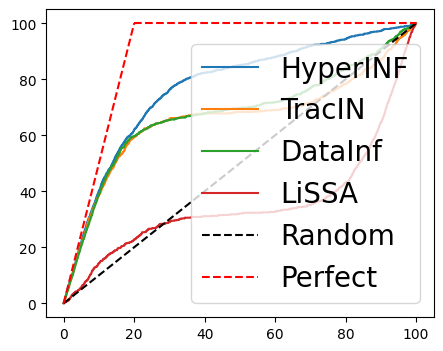

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

## set seed for production
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## model's settings
model_name_or_path="roberta-large"
task = "mrpc"
noise_ratio=0.2
batch_size=32
rank = 16
target_modules=["value","query"]
device="cuda"
num_epochs=15
lr= 3e-5

## load data
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                            task=task,
                                            noise_ratio=noise_ratio,
                                            batch_size=batch_size)
train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn=dataloader_outputs

## LoRA Model
lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            lora=True,
                            low_rank=rank,
                            task=task)


lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

## get the train_grad and val_grad from fine-tuned model
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)
## to cuda
for key in tr_grad_dict:
    for kk in tr_grad_dict[key]:
        tr_grad_dict[key][kk] = tr_grad_dict[key][kk].to(device)

for key in val_grad_dict:
    for kk in val_grad_dict[key]:
        val_grad_dict[key][kk] = val_grad_dict[key][kk].to(device)


## compute influence function
influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)

influence_engine.compute_hvps(compute_accurate=False)
influence_engine.compute_IF()

n_train=influence_engine.n_train
true_label=np.zeros(n_train)
true_label[noise_index]=1

method_dict={
    'identity': 'TracIN',
            'proposed': 'DataInf',
            'iterative': 'HyperINF',
            'LiSSA': 'LiSSA'
            }

## plot the detection-ratio
plt.figure(figsize=(5,4))

for method in influence_engine.IF_dict:
    detection_rate_list=[]
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    for ind in range(1, len(low_quality_to_high_quality)+1):
        # detected_samples: the samples that are detected as noise
        detected_samples = set(low_quality_to_high_quality[:ind]).intersection(noise_index)
        detection_rate = 100*len(detected_samples)/len(noise_index)
        detection_rate_list.append(detection_rate)


    plt.plot(100*np.arange(len(low_quality_to_high_quality))/n_train,
            detection_rate_list,
            #marker='s',
            label=method_dict[method])


## plot random detection rate from (0,0) to (100,100)
plt.plot([0, 100], [0, 100], linestyle='--', color='black', label='Random')
## plot perfect detection rate from (0,0) to (20,100), (20,100) to (100,100)
plt.plot([0, 20], [0, 100], linestyle='--', color='red', label='Perfect')
plt.plot([20, 100], [100, 100], linestyle='--', color='red')
plt.legend(fontsize=20)
plt.show()

## 3. Running Time Comparison
- Gaussian Elimination
- Fast Faussian Elimination (torch.inverse)
- GMRES approximation with Scipy and torch adaptation
- the Schulz's method

In [1]:
### Updated torch linalg
### adapted from https://github.com/devzhk/Pytorch-linalg
import torch
from functools import partial
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

def _check_nan(vec, msg):
    if torch.isnan(vec).any():
        raise ValueError(msg)


def _safe_normalize(x, threshold=None):
    norm = torch.norm(x)
    if threshold is None:
        threshold = torch.finfo(norm.dtype).eps
    normalized_x = x / norm if norm > threshold else torch.zeros_like(x)
    return normalized_x, norm


def Mvp(A, vec):
    return A @ vec


def arnoldi(vec,    # Matrix vector product
            V,      # List of existing basis
            H,      # H matrix
            j):     # number of basis
    '''
    Arnoldi iteration to find the j th l2-orthonormal vector
    compute the j-1 th column of Hessenberg matrix
    '''
    _check_nan(vec, 'Matrix vector product is Nan')

    for i in range(j):
        H[i, j - 1] = torch.dot(vec, V[i])
        vec = vec - H[i, j-1] * V[i]
    new_v, vnorm = _safe_normalize(vec)
    H[j, j - 1] = vnorm
    return new_v


def cal_rotation(a, b):
    '''
    Args:
        a: element h in position j
        b: element h in position j+1
    Returns:
        cosine = a / \sqrt{a^2 + b^2}
        sine = - b / \sqrt{a^2 + b^2}
    '''
    c = torch.sqrt(a * a + b * b)
    return a / c, - b / c


def apply_given_rotation(H, cs, ss, j):
    '''
    Apply givens rotation to H columns
    :param H:
    :param cs:
    :param ss:
    :param j:
    :return:
    '''
    # apply previous rotation to the 0->j-1 columns
    for i in range(j):
        tmp = cs[i] * H[i, j] - ss[i] * H[i + 1, j]
        H[i + 1, j] = cs[i] * H[i+1, j] + ss[i] * H[i, j]
        H[i, j] = tmp
    cs[j], ss[j] = cal_rotation(H[j, j], H[j + 1, j])
    H[j, j] = cs[j] * H[j, j] - ss[j] * H[j + 1, j]
    H[j + 1, j] = 0
    return H, cs, ss


'''
    GMRES solver for solving Ax=b.
    Reference: https://web.stanford.edu/class/cme324/saad-schultz.pdf
'''

def GMRES(A,                # Linear operator, matrix or function
          b,                # RHS of the linear system in which the first half has the same shape as grad_gx, the second half has the same shape as grad_fy
          x0=None,          # initial guess, tuple has the same shape as b
          max_iter=None,    # maximum number of GMRES iterations
          tol=1e-6,         # relative tolerance
          atol=1e-6,        # absolute tolerance
          track=False):     # If True, track the residual error of each iteration
    '''
    Return:
        sol: solution
        (j, err_history):
            j is the number of iterations used to achieve the target accuracy;
            err_history is a list of relative residual error at each iteration if track=True, empty list otherwise.
    '''
    if isinstance(A, torch.Tensor):
        Avp = partial(Mvp, A)
    elif hasattr(A, '__call__'):
        Avp = A
    else:
        raise ValueError('A must be a function or matrix')

    bnorm = torch.norm(b)

    if max_iter == 0 or bnorm < 1e-8:
        return b

    if max_iter is None:
        max_iter = b.shape[0]

    if x0 is None:
        x0 = torch.zeros_like(b)
        r0 = b
    else:
        r0 = b - Avp(x0)

    new_v, rnorm = _safe_normalize(r0)
    # initial guess residual
    beta = torch.zeros(max_iter + 1, device=b.device)
    beta[0] = rnorm
    err_history = []
    if track:
        err_history.append((rnorm / bnorm).item())

    V = []
    V.append(new_v)
    H = torch.zeros((max_iter + 1, max_iter + 1), device=b.device)
    cs = torch.zeros(max_iter, device=b.device)  # cosine values at each step
    ss = torch.zeros(max_iter, device=b.device)  # sine values at each step

    for j in range(max_iter):
        p = Avp(V[j])
        new_v = arnoldi(p, V, H, j + 1)  # Arnoldi iteration to get the j+1 th basis
        V.append(new_v)

        H, cs, ss = apply_given_rotation(H, cs, ss, j)
        beta[j + 1] = ss[j] * beta[j]
        beta[j] = cs[j] * beta[j]
        residual = torch.abs(beta[j + 1])
        if track:
            err_history.append((residual / bnorm).item())
        if residual < tol * bnorm or residual < atol:
            break
    y, _ = torch.triangular_solve(beta[0:j + 1].unsqueeze(-1), H[0:j + 1, 0:j + 1])  # j x j
    V = torch.stack(V[:-1], dim=0)
    sol = x0 + V.T @ y.squeeze(-1)
    return sol, (j, err_history)


'''
  Conjugate Gradient algorithm for solving Ax=b.
  Reference: https://en.wikipedia.org/wiki/Conjugate_gradient_method
'''

def CG(A,                   # linear operator
       b,                   # RHS of the linear system
       x0=None,             # initial guess
       max_iter=None,       # maximum number of iterations
       tol=1e-5,            # relative tolerance
       atol=1e-6,           # absolute tolerance
       track=False,         # if True, track the residual error of each iteration
       ):
    '''
    Return:
        sol: solution
        (j, err_history):
            j is the number of iterations used to achieve the target accuracy;
            err_history is a list of relative residual error at each iteration if track=True, empty list otherwise.
    '''
    if isinstance(A, torch.Tensor):
        Avp = partial(Mvp, A)
    elif hasattr(A, '__call__'):
        Avp = A
    else:
        raise ValueError('A must be a function or squared matrix')

    if max_iter is None:
        max_iter = b.shape[0]
    if x0 is None:
        x = torch.zeros_like(b)
        r = b.detach().clone()
    else:
        Av = Avp(x0)
        r = b.detach().clone() - Av
        x = x0

    p = r.clone()
    rdotr = torch.dot(r, r)
    err_history = []
    if track:
        err_history.append(rdotr.item())

    residual_tol = max(tol * tol * torch.dot(b, b), atol * atol)
    if rdotr < residual_tol:
        return x, 0

    for i in range(max_iter):
        Ap = Avp(p)

        alpha = rdotr / torch.dot(p, Ap)
        x.add_(alpha * p)
        r.add_(-alpha * Ap)
        new_rdotr = torch.dot(r, r)
        beta = new_rdotr / rdotr
        p = r + beta * p
        rdotr = new_rdotr
        if track:
            err_history.append(rdotr.item())
        if rdotr < residual_tol:
            break
    return x, (i + 1, err_history)

In [2]:
import numpy as np
from scipy.sparse.linalg import gmres

def scipy_gmres_inverse(A, tol=1e-6, maxiter=None):
    """
    Compute the inverse of a matrix using the GMRES method.

    Parameters:
    A : numpy.ndarray
        A square matrix to invert.
    tol : float
        Tolerance for convergence (default 1e-8).
    maxiter : int or None
        Maximum number of iterations (default None, i.e., no limit).

    Returns:
    numpy.ndarray
        The inverse of the matrix A.
    """
    n = A.shape[0]
    A_inv = np.zeros_like(A, dtype=np.float64)
    identity = np.eye(n)

    for i in range(n):
        b = identity[:, i]
        x, _ = gmres(A, b, atol=tol, maxiter=maxiter)
        A_inv[:, i] = x
    return A_inv

def pytorch_gmres_inverse(A, tol=1e-6, maxiter=None):
    """
    Compute the inverse of a matrix using the GMRES method (pytorch).
    """
    n = A.shape[0]
    A_inv = torch.zeros_like(A).to(A.device)
    identity = torch.eye(n).to(A.device)

    for i in range(n):
        b = identity[:, i]
        x, _ = GMRES(A, b, atol=tol, max_iter=maxiter)
        A_inv[:, i] = x

    return A_inv

def conjugate_gradient_inverse(A, tol=1e-6, maxiter=None):
    """
    Compute the inverse of a matrix using the gradient conjugate method.
    """
    n = A.shape[0]
    A_inv = torch.zeros_like(A).to(A.device)
    identity = torch.eye(n).to(A.device)

    for i in range(n):
        b = identity[:, i]
        x, _ = CG(A, b, atol=tol, max_iter=maxiter)
        A_inv[:, i] = x

    return A_inv


def gaussian_elimination_inverse(A):
    """
    Compute the inverse of a matrix using Gaussian elimination.

    Parameters:
    A : torch.Tensor
        A square matrix to invert.

    Returns:
    torch.Tensor
        The inverse of the matrix A, if it exists. Otherwise, raises an error.
    """
    # Ensure A is a float tensor for precision and avoid integer division issues
    A = A.float()

    n = A.shape[0]
    assert A.shape[1] == n, "Matrix must be square"

    # Create an augmented matrix with the identity matrix on the right
    augmented = torch.cat((A, torch.eye(n).to(A.device)), dim=1).to(A.device)

    # Gaussian elimination
    for i in range(n):
        # Find the pivot element and swap rows if necessary
        max_row = torch.argmax(torch.abs(augmented[i:, i])) + i
        if augmented[max_row, i] == 0:
            raise ValueError("Matrix is singular and cannot be inverted.")

        if max_row != i:
            # Swap rows
            augmented[[i, max_row]] = augmented[[max_row, i]]

        # Normalize the pivot row
        pivot = augmented[i, i]
        augmented[i] = augmented[i] / pivot

        # Eliminate all other entries in the current column
        for j in range(n):
            if j != i:
                factor = augmented[j, i]
                augmented[j] -= factor * augmented[i]

    # The right half of the augmented matrix is now the inverse of the original matrix
    A_inv = augmented[:, n:]
    return A_inv

# Example usage
if __name__ == "__main__":
    # A = np.array([[4, 1, 0], [1, 4, 1], [0, 1, 4]])
    A = torch.tensor([[4, 1, 0], [1, 4, 1], [0, 1, 4]], dtype=torch.float32).to('cuda')
    A_inv_gmres = pytorch_gmres_inverse(A)
    A_inv_cg = conjugate_gradient_inverse(A)
    A_inv_gaussian = gaussian_elimination_inverse(A)
    print("Inverse of A:")
    print(A_inv_gmres.shape)
    print("Product of A and A_inv (should be close to identity):")
    print(torch.matmul(A, A_inv_gmres))
    print(torch.matmul(A, A_inv_cg))
    print(torch.matmul(A, A_inv_gaussian))


Inverse of A:
torch.Size([3, 3])
Product of A and A_inv (should be close to identity):
tensor([[ 1.0000e+00,  0.0000e+00, -7.4506e-09],
        [-2.2352e-08,  1.0000e+00, -2.9802e-08],
        [-7.4506e-09,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([[1.0000e+00, 0.0000e+00, 7.4506e-09],
        [1.1176e-08, 1.0000e+00, 0.0000e+00],
        [7.4506e-09, 0.0000e+00, 1.0000e+00]], device='cuda:0')
tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 9.3132e-09,  1.0000e+00, -2.9802e-08],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


/tmp/ipykernel_123932/503960675.py:149: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  y, _ = torch.triangular_solve(beta[0:j + 1].unsqueeze(-1), H[0:j + 1, 0:j + 1])  # j x j


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import time
from scipy.sparse.linalg import gmres

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE: ", device)

def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def schulz_inverse_stable(A, damping_factor=0.001, max_iterations=20, tol=1e-6, X_0_const=0.00005):
    n = A.shape[0]
    I = torch.eye(n, device=A.device, dtype=A.dtype)
    A = A + damping_factor * I
    X = torch.eye(n, device=A.device) * X_0_const

    for i in range(max_iterations):
        X = X @ (2 * I - A @ X)

    return X


d = [16,64,256,1024,4096,16384]
# d = [4096]
Ns = 12800
damping_factor = 0.1

result_dict = {
    "dim": d,
    "ge_time": [],
    "fge_time": [],
    "schulz_time": [],
    "gmres_scipy_time": [],
    "gmres_torch_time": [],
}

for dim in d:
    ge_time = []
    fge_time = []
    schulz_time = []
    gmres_time = []
    gmres_torch_time = []

    schulz_errors = []
    gmres_errors = []
    gmres_torch_errors = []
    fge_errors = []
    print("Dimension: ", dim)

    if dim == 16384:
        damping_factor = 1.0 ## make sure it is invertible
        x0_const = 0.000005
    else:
        damping_factor = 0.1
        x0_const = 0.00005


    for seed in range(3):
        set_seed(seed=seed)
        time_schulz = 0
        time_inv = 0

        A = torch.zeros((dim, dim)).to(device)
        for _ in range(Ns):
            tmp = torch.randn((dim, 1)).to(device)
            A += tmp @ tmp.T

        I = torch.eye(dim, device=A.device)
        A = A + damping_factor * I

        if dim <= 1024:
            st_time = time.time()
            ## Exact Inverse by Gaussian Elimination
            A_inv_ge = gaussian_elimination_inverse(A)
            time_ge = time.time() - st_time
            print("Gaussian Elimination Time: ", time_ge)
            ge_time.append(time_ge)

            st_time = time.time()
            ## Compute inverse by GMRES (scipy.linalg.gmres)
            A_inv_gmres_scipy = scipy_gmres_inverse(A.cpu().numpy(), tol=1e-6, maxiter=20)
            time_gmres = time.time() - st_time
            print("GMRES(scipy) Time: ", time_gmres)
            gmres_time.append(time_gmres)

        st_time = time.time()
        ## Faster Gaussian Elimination by (torch.inverse)
        A_inv = torch.inverse(A)
        time_inv = time.time() - st_time
        print("Faster Gaussian Elimination Time (torch.inverse): ", time_inv)
        fge_time.append(time_inv)

        st_time = time.time()
        ## Compute inverse by GMRES (rewrite in pytorch, enable GPU acceleration)
        A_inv_gmres_torch = pytorch_gmres_inverse(A, tol=1e-6, maxiter=20)
        time_gmres_torch = time.time() - st_time
        print("GMRES(torch) Time: ", time_gmres_torch)
        gmres_torch_time.append(time_gmres_torch)

        st_time = time.time()
        ## Compute inverse by Schulz method
        A_inv_schulz = schulz_inverse_stable(A, damping_factor=0, max_iterations=20, tol=1e-6, X_0_const=x0_const)
        time_schulz = time.time() - st_time
        print("Schulz Time: ", time_schulz)
        schulz_time.append(time_schulz)

        ## compute the approximation errors by Frobenius distance
        if dim <= 1024:
            fge_error = torch.norm(A_inv_ge*1e4 - A_inv*1e4, p='fro').item() /1e4
            fge_errors.append(fge_error)
            print("(torch.inverse) Error: ", fge_error)

            gmres_scipy_error = np.linalg.norm(A_inv_ge.cpu().numpy()*1e4 - A_inv_gmres_scipy*1e4, ord='fro').item() /1e4
            gmres_errors.append(gmres_scipy_error)
            print("GMRES (scipy) Error: ", gmres_scipy_error)

            sc_error = torch.norm(A_inv_ge*1e4 - A_inv_schulz*1e4, p='fro').item() /1e4
            schulz_errors.append(sc_error)
            print("Schulz Error: ", sc_error)
            gmres_torch_error = torch.norm(A_inv_ge*1e4 - A_inv_gmres_torch*1e4, p='fro').item() /1e4
            gmres_torch_errors.append(gmres_torch_error)
            print("GMRES (torch) Error: ", gmres_torch_error)
        else:
            sc_error = torch.norm(A_inv*1e4 - A_inv_schulz*1e4, p='fro').item() /1e4
            schulz_errors.append(sc_error)
            print("Schulz Error: ", sc_error)
            gmres_torch_error = torch.norm(A_inv*1e4 - A_inv_gmres_torch*1e4, p='fro').item() /1e4
            gmres_torch_errors.append(gmres_torch_error)
            print("GMRES (torch) Error: ", gmres_torch_error)


    ## take the average of the times
    print(f"====== Summary on Dim {dim} ======")
    print("-->> Time Cost (s)")
    if dim <= 1024:
      result_dict["ge_time"].append(np.mean(ge_time))
      result_dict["gmres_scipy_time"].append(np.mean(gmres_time))
      print("Gaussian Elimination: ", np.mean(ge_time), "±", np.std(ge_time))
      print("GMRES (scipy): ", np.mean(gmres_time), "±", np.std(gmres_time))

    result_dict["fge_time"].append(np.mean(fge_time))
    result_dict["schulz_time"].append(np.mean(schulz_time))
    result_dict["gmres_torch_time"].append(np.mean(gmres_torch_time))
    print("(torch.inverse): ", np.mean(fge_time), "±", np.std(fge_time))
    print("GMRES (torch): ", np.mean(gmres_torch_time), "±", np.std(gmres_torch_time))
    print("Schulz Time: ", np.mean(schulz_time), "±", np.std(schulz_time))
    print()

    print("-->> Speedup Ratio")
    if dim <= 1024:
        print(f"GMRES(scipy)/ge = {100*np.mean(gmres_time)/np.mean(ge_time)}%")
        print(f"GMRES(torch)/ge = {100*np.mean(gmres_torch_time)/np.mean(ge_time)}%")
        print(f"Schulz/ge = {100*np.mean(schulz_time)/np.mean(ge_time)}%")
        print()
        print(f"GMRES(scipy)/ge = {100*np.mean(gmres_time)/np.mean(fge_time)}%")
    print(f"GMRES(torch)/fge = {100*np.mean(gmres_torch_time)/np.mean(fge_time)}%")
    print(f"Schulz/fge = {100*np.mean(schulz_time)/np.mean(fge_time)}%")
    print()

    print("-->> Error")
    if dim <= 1024:
        print("FGE (torch.inverse): ", np.mean(fge_errors), "±", np.std(fge_errors))
        print("GMRES (scipy): ", np.mean(gmres_errors), "±", np.std(gmres_errors))
    print("GMRES (torch): ", np.mean(gmres_torch_errors), "±", np.std(gmres_torch_errors))
    print("Schulz: ", np.mean(schulz_errors), "±", np.std(schulz_errors))
    print("=============================")


## take the average of the times
#print("Exact Time: ", np.mean(exact_time), "±", np.std(exact_time))
#print("Schulz Time: ", np.mean(schulz_time), "±", np.std(schulz_time))

DEVICE:  cuda
Dimension:  16


Gaussian Elimination Time:  0.00794219970703125
GMRES(scipy) Time:  0.02333521842956543
Faster Gaussian Elimination Time (torch.inverse):  0.012070178985595703
GMRES(torch) Time:  0.04490160942077637
Schulz Time:  0.004580497741699219
(torch.inverse) Error:  2.6009487896772045e-11
GMRES (scipy) Error:  1.8275714380897133e-10
Schulz Error:  4.8822772669154804e-11
GMRES (torch) Error:  1.8345793932894593e-10
Gaussian Elimination Time:  0.007309436798095703
GMRES(scipy) Time:  0.0051767826080322266
Faster Gaussian Elimination Time (torch.inverse):  0.0004572868347167969
GMRES(torch) Time:  0.05521249771118164
Schulz Time:  0.0007293224334716797
(torch.inverse) Error:  3.155670356136397e-11
GMRES (scipy) Error:  4.4291992578860617e-10
Schulz Error:  3.629238563007675e-11
GMRES (torch) Error:  1.0623186881275614e-10
Gaussian Elimination Time:  0.0071222782135009766
GMRES(scipy) Time:  0.004746198654174805
Faster Gaussian Elimination Time (torch.inverse):  0.0005347728729248047
GMRES(torch) 